In [1]:
#Instalamos las dependencias necesarias que no posee Google Colab.
%pip install bayesian-optimization
%pip install mlxtend --upgrade --no-deps
%pip install tensorflow
%pip install imbalanced-learn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Preprocesamiento de los datos

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Input, GRU, Dense, Dropout, BatchNormalization, Activation, Multiply, concatenate, dot
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Leer los conjuntos de datos
train = pd.read_csv("UNSW_NB15_training-set.csv")
test = pd.read_csv("UNSW_NB15_testing-set.csv")

# Reemplazar '-' con np.nan en ambos DataFrames
train = train.replace("-", np.nan)
test = test.replace("-", np.nan)

# Eliminar la columna 'service' (muchos valores faltantes o irrelevantes)
train = train.drop('service', axis=1)
test = test.drop('service', axis=1)

# Codificación de las columnas categóricas 'proto' y 'state'
categorical_cols = ['proto', 'state']

# Inicializar el OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Ajustar y transformar los datos de entrenamiento
train_encoded = encoder.fit_transform(train[categorical_cols]).toarray()

# Transformar los datos de prueba utilizando el mismo encoder
test_encoded = encoder.transform(test[categorical_cols]).toarray()

# Convertir a DataFrame los datos codificados
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Eliminar las columnas categóricas originales
train = train.drop(columns=categorical_cols)
test = test.drop(columns=categorical_cols)

# Concatenar los DataFrames codificados con los originales
train = pd.concat([train, train_encoded_df], axis=1)
test = pd.concat([test, test_encoded_df], axis=1)

# Eliminar la columna 'id' (no aporta información útil)
train = train.drop(columns='id')
test = test.drop(columns='id')

# Dividir en características (X) y etiquetas (y)
X_train = train.loc[:, train.columns != 'attack_cat']
y_train = train['attack_cat']

X_test = test.loc[:, test.columns != 'attack_cat']
y_test = test['attack_cat']

# Codificar etiquetas categóricas a numéricas para clasificación multiclasificada
label_encoder = LabelEncoder()
y_train_multi = label_encoder.fit_transform(y_train)
y_test_multi = label_encoder.transform(y_test)

# Crear etiquetas binarias (0: Normal, 1: Ataque)
y_train_binary = y_train.apply(lambda x: 0 if x == 'Normal' else 1).astype('float32')
y_test_binary = y_test.apply(lambda x: 0 if x == 'Normal' else 1).astype('float32')

# Asegurar que las etiquetas multiclasificadas sean de tipo int32
y_train_multi = y_train_multi.astype('int32')
y_test_multi = y_test_multi.astype('int32')

# Escalar los datos numéricos
scaler = StandardScaler()

# Ajustar el escalador con los datos de entrenamiento y transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar la forma de los datos para GRU (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

# Definición de funciones

In [3]:
# Función de atención general
def attention_layer(inputs):

    # Capa Dense para calcular los pesos de atención
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Activation('softmax')(attention_weights)
    attention_output = Multiply()([inputs, attention_weights])
    return attention_output

# Crear el modelo GRU con regularización y atención
def build_gru_model(regularization_type, attention_type, input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Capa GRU inicial con regularización
    if regularization_type == 'dropout':
        x = GRU(128, return_sequences=True)(inputs)
        x = Dropout(0.5)(x)
    elif regularization_type == 'l2':
        x = GRU(128, return_sequences=True, kernel_regularizer=l2(0.01))(inputs)
    elif regularization_type == 'batch_norm':
        x = GRU(128, return_sequences=True)(inputs)
        x = BatchNormalization()(x)
    elif regularization_type == 'early_stopping':
        x = GRU(128, return_sequences=True)(inputs)
    else:
        x = GRU(128, return_sequences=True)(inputs)

    # Mecanismos de atención
    if attention_type == 'self_attention':
        # Atención sobre las propias salidas de la GRU
        attention = attention_layer(x)
        x = attention  
    elif attention_type == 'contextual_attention':
        # Atención utilizando un contexto externo
        context = Input(shape=input_shape)
        attention_weights = dot([x, context], axes=[2, 2])
        attention_weights = Activation('softmax')(attention_weights)
        attention_output = Multiply()([x, attention_weights])
        x = attention_output
        inputs = [inputs, context]  
    elif attention_type == 'simple_attention':
        # Atención simple con capa Dense
        attention = Dense(1, activation='tanh')(x)
        attention_weights = Activation('softmax')(attention)
        attention_output = Multiply()([x, attention_weights])
        x = attention_output
    elif attention_type == 'seq2seq_attention':
        # Atención  seq2seq
        encoder_outputs, state_h = GRU(128, return_sequences=True, return_state=True)(inputs)
        decoder_inputs = Input(shape=input_shape)
        decoder_outputs = GRU(128, return_sequences=True)(decoder_inputs, initial_state=state_h)
        attention_weights = dot([decoder_outputs, encoder_outputs], axes=[2, 2])
        attention_weights = Activation('softmax')(attention_weights)
        attention_output = dot([attention_weights, encoder_outputs], axes=[2, 1])
        x = attention_output
        inputs = [inputs, decoder_inputs]  
    else:
        pass  

    x = GRU(64)(x)

    # clasificación 
    outputs = Dense(num_classes, activation='softmax')(x)

    # Modelo
    if attention_type in ['contextual_attention']:
        model = Model(inputs=inputs, outputs=outputs)
    elif attention_type == 'seq2seq_attention':
        model = Model(inputs=inputs, outputs=outputs)
    else:
        model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model




# Ejecutar modelos

In [4]:
# Listas para almacenar resultados
history_list = []
model_names = []
confusion_matrices_binary = []
confusion_matrices_multi = []

# Definir las técnicas de regularización y mecanismos de atención a probar
regularization_techniques = ['dropout', 'l2', 'batch_norm', 'early_stopping']
attention_mechanisms = ['self_attention', 'simple_attention', 'seq2seq_attention']

# Tipos de ataque + Normal
num_classes = len(label_encoder.classes_)

for reg in regularization_techniques:
    for att in attention_mechanisms:
        # Nombre de modelo
        model_name = f"{reg.upper()} + {att.upper()}"
        print(f"\nEntrenando modelo: {model_name}")

        # Construir el modelo
        input_shape = (X_train_scaled.shape[1], 1)
        model = build_gru_model(reg, att, input_shape, num_classes)

        # EarlyStopping
        callbacks = []
        if reg == 'early_stopping':
            early_stopping = EarlyStopping(monitor='val_loss', patience=5)
            callbacks.append(early_stopping)

        # Preparar datos adicionales si es necesario
        if att == 'contextual_attention':
            context_data = X_train_scaled  
            val_context_data = X_test_scaled
            train_inputs = [X_train_scaled, context_data]
            val_inputs = [X_test_scaled, val_context_data]
        elif att == 'seq2seq_attention':
            decoder_input_data = X_train_scaled  
            val_decoder_input_data = X_test_scaled
            train_inputs = [X_train_scaled, decoder_input_data]
            val_inputs = [X_test_scaled, val_decoder_input_data]
        else:
            train_inputs = X_train_scaled
            val_inputs = X_test_scaled

        # Entrenar el modelo
        history = model.fit(
            train_inputs, y_train_multi,
            epochs=3,
            batch_size=200,
            validation_data=(val_inputs, y_test_multi),
            callbacks=callbacks,
            verbose=1
        )
        
        history_list.append(history)
        model_names.append(model_name)

        # Realizar predicciones sobre el conjunto de prueba
        y_pred_probs = model.predict(val_inputs)
        y_pred_multi = np.argmax(y_pred_probs, axis=1)

        # Matriz de confusión tipos de ataque
        cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
        confusion_matrices_multi.append(cm_multi)

        # Convertir predicciones y etiquetas a binarias para normal-ataque
        y_pred_binary = np.where(y_pred_multi == label_encoder.transform(['Normal'])[0], 0, 1)
        y_test_binary_actual = y_test_binary.astype('int32')

        # Matriz de confusión normal-ataque
        cm_binary = confusion_matrix(y_test_binary_actual, y_pred_binary)
        confusion_matrices_binary.append(cm_binary)



Entrenando modelo: DROPOUT + SELF_ATTENTION
Epoch 1/3
877/877 [==============================] - 1006s 1s/step - loss: 1.1507 - accuracy: 0.5987 - val_loss: 0.8466 - val_accuracy: 0.6947
Epoch 2/3
877/877 [==============================] - 948s 1s/step - loss: 0.6485 - accuracy: 0.7728 - val_loss: 0.6684 - val_accuracy: 0.7630
Epoch 3/3
2573/2573 [==============================] - 60s 23ms/step

Entrenando modelo: DROPOUT + SIMPLE_ATTENTION
Epoch 1/3
877/877 [==============================] - 571s 650ms/step - loss: 1.2682 - accuracy: 0.5597 - val_loss: 1.1074 - val_accuracy: 0.6539
Epoch 2/3
877/877 [==============================] - 579s 660ms/step - loss: 1.0151 - accuracy: 0.6551 - val_loss: 0.6545 - val_accuracy: 0.7766
Epoch 3/3
2573/2573 [==============================] - 64s 25ms/step

Entrenando modelo: DROPOUT + SEQ2SEQ_ATTENTION
Epoch 1/3
877/877 [==============================] - 1611s 2s/step - loss: 0.7703 - accuracy: 0.7268 - val_loss: 0.4546 - val_accuracy: 0.8200
Epoc


# Gráficas de resultados

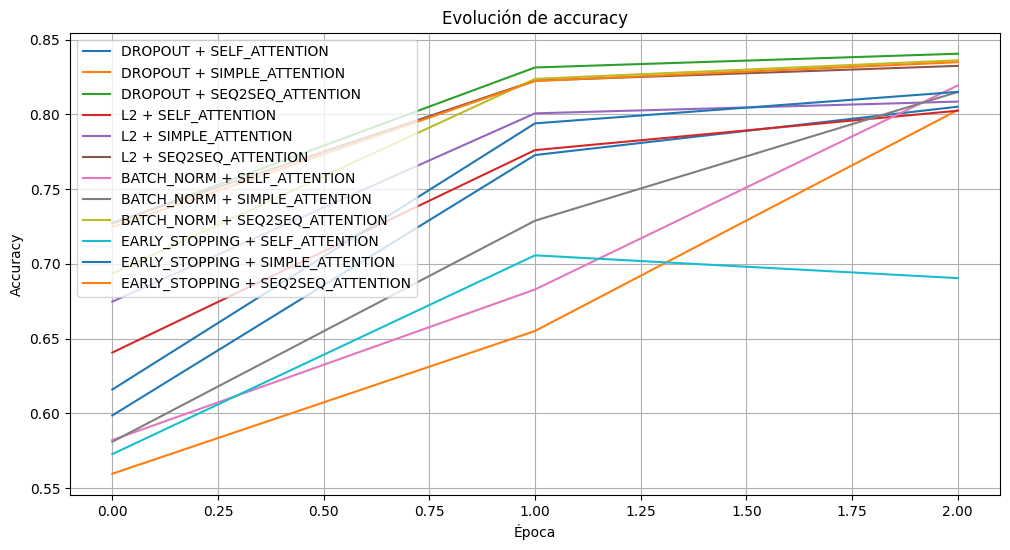

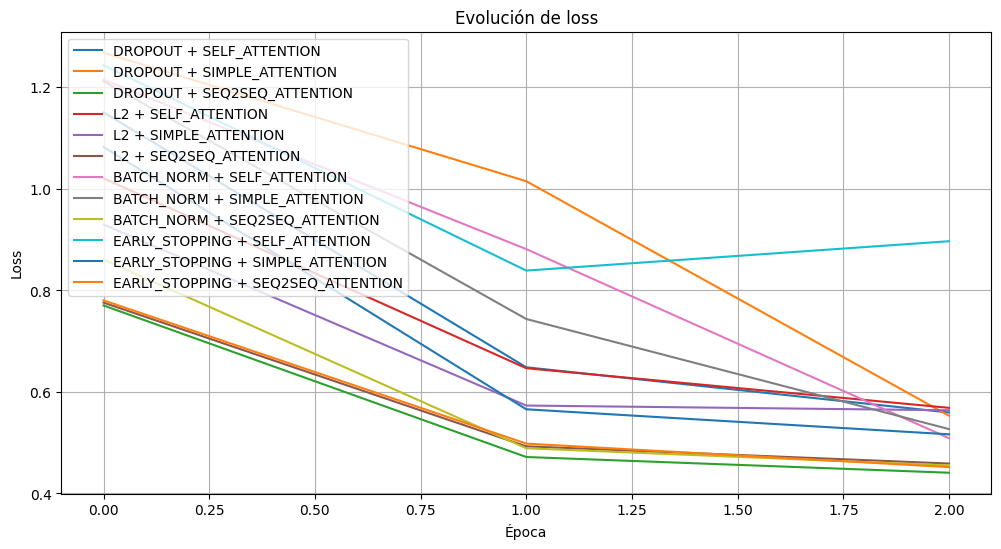

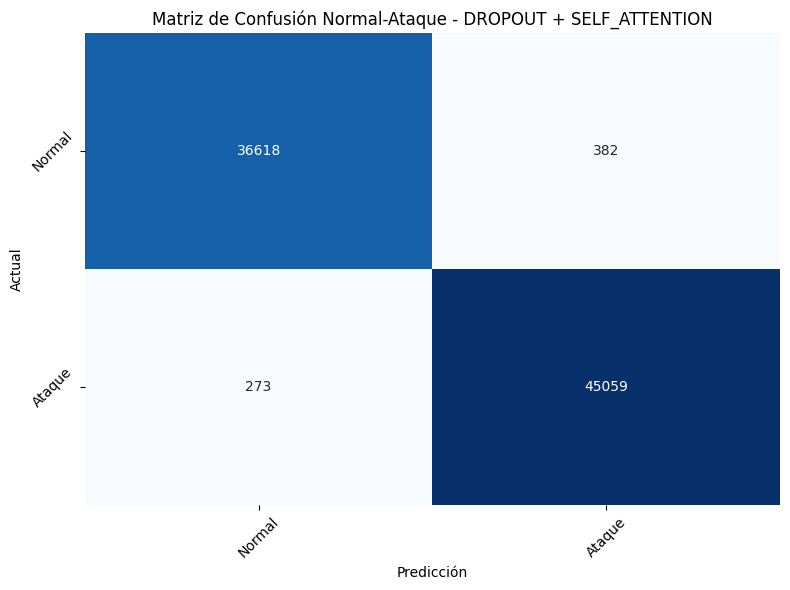

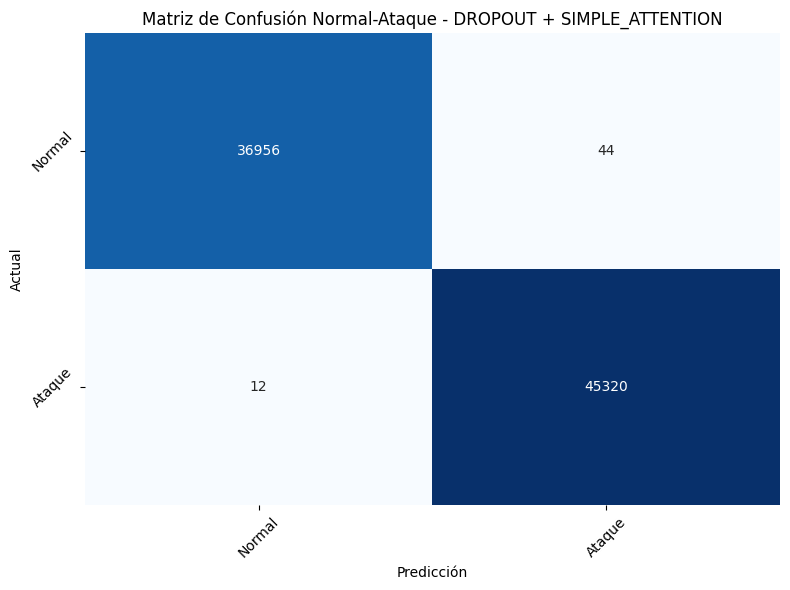

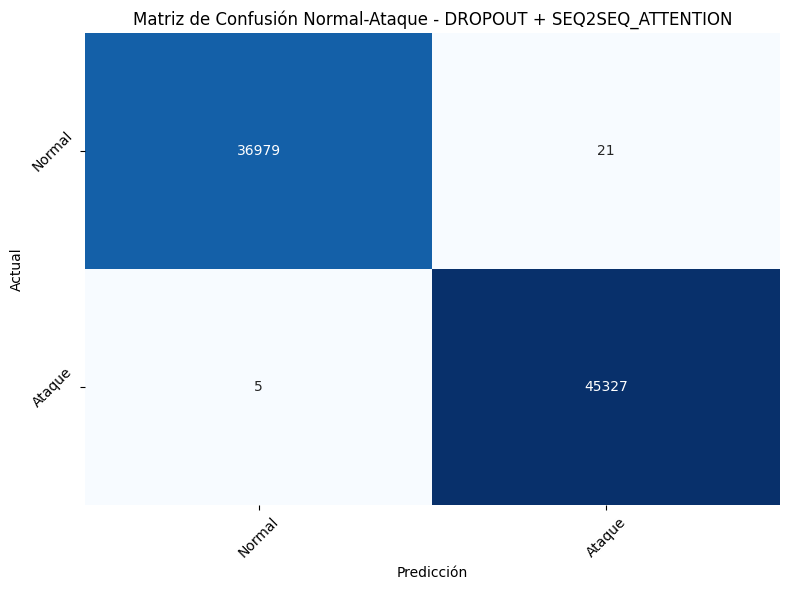

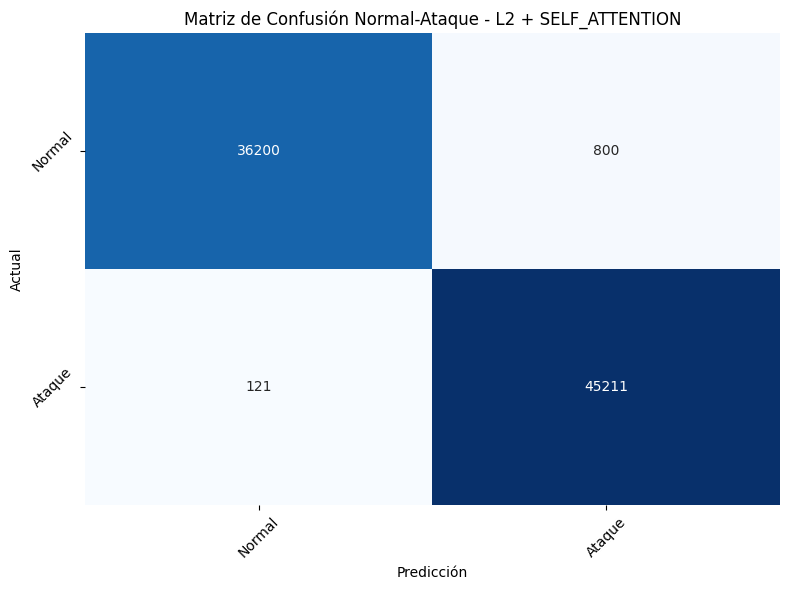

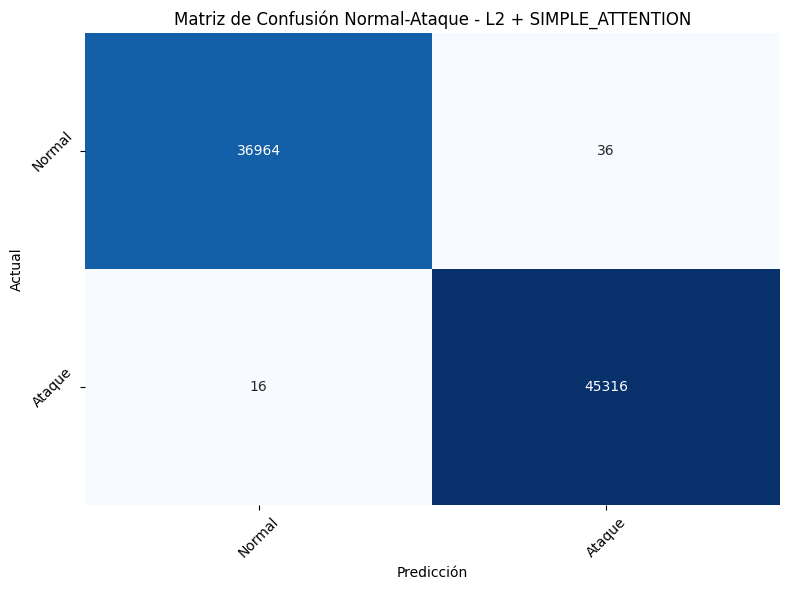

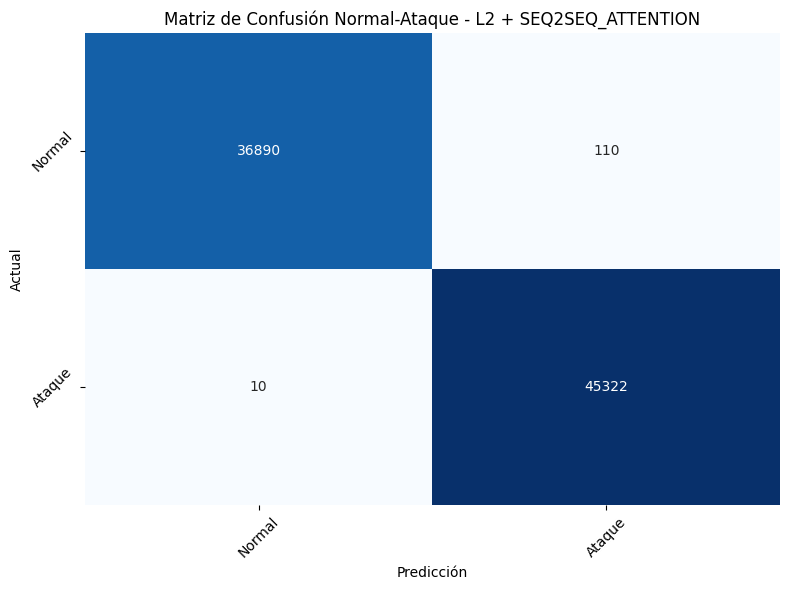

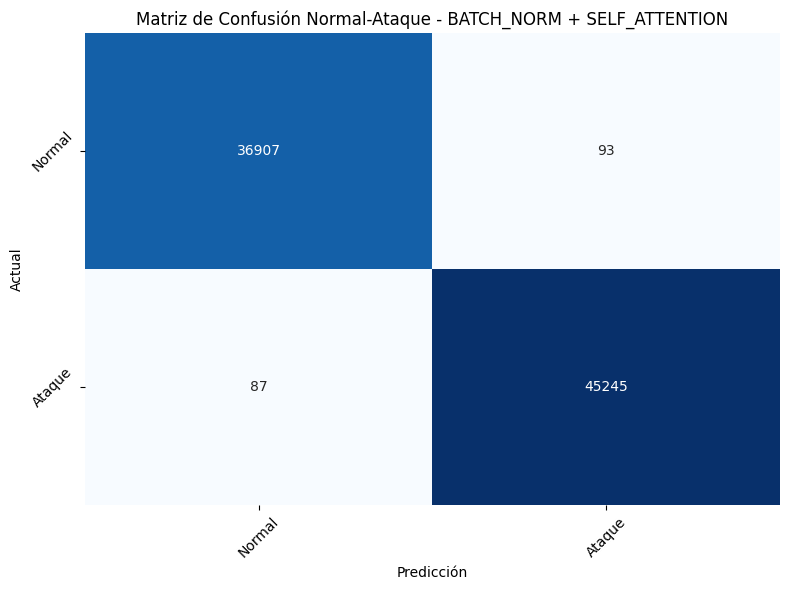

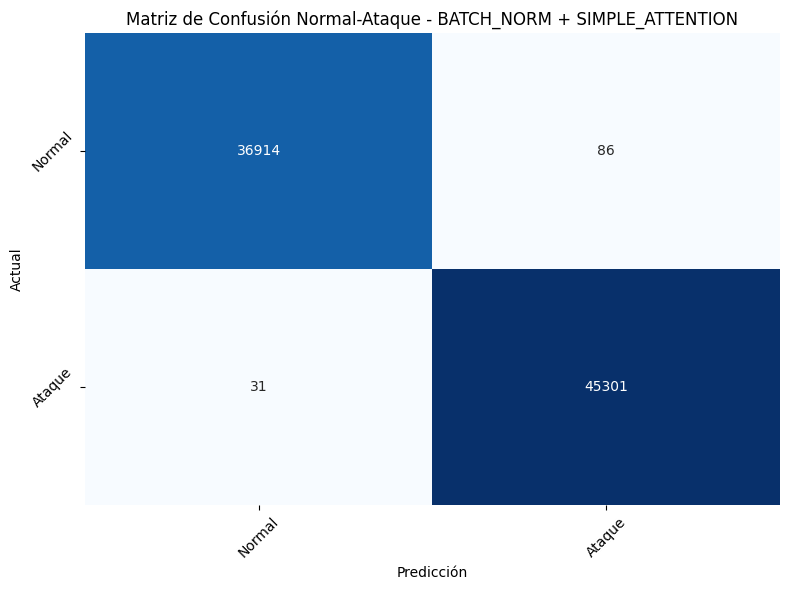

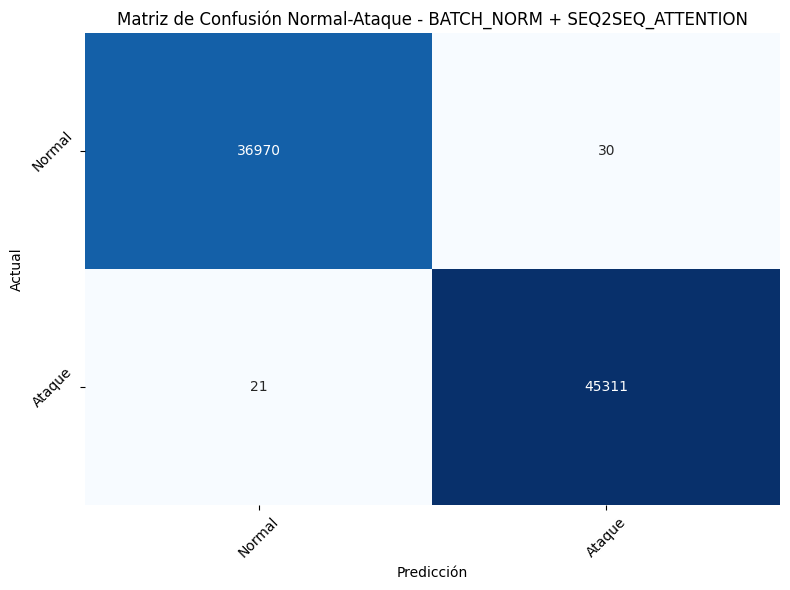

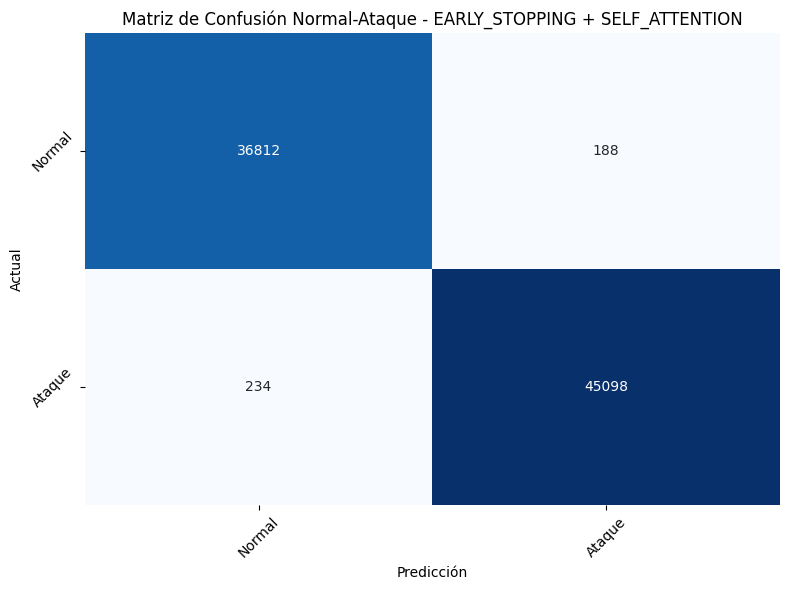

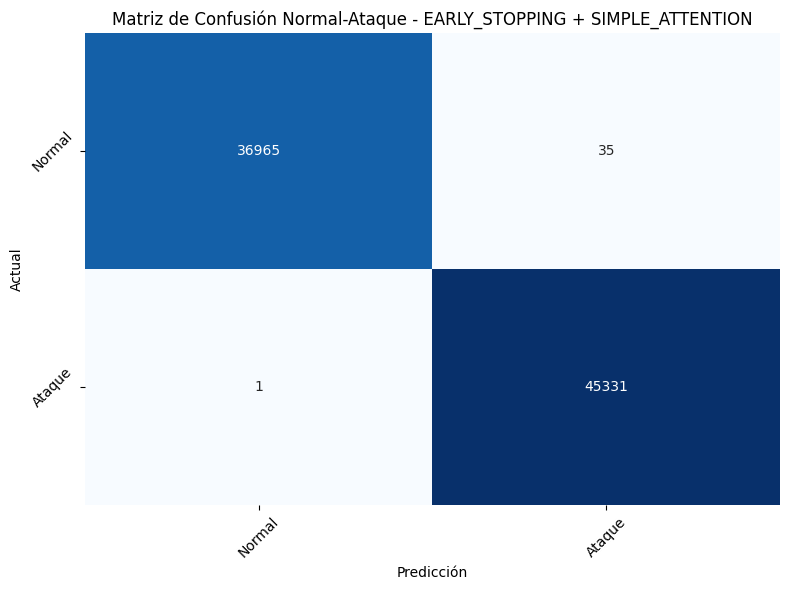

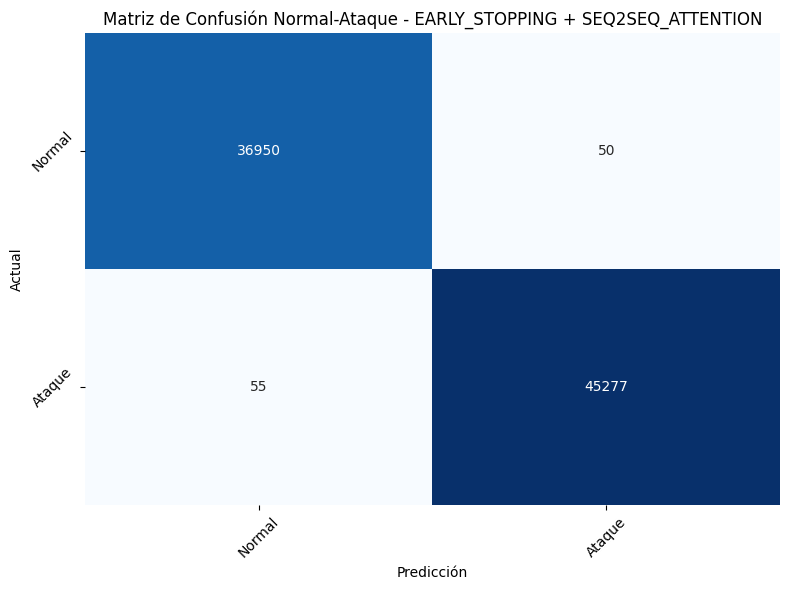

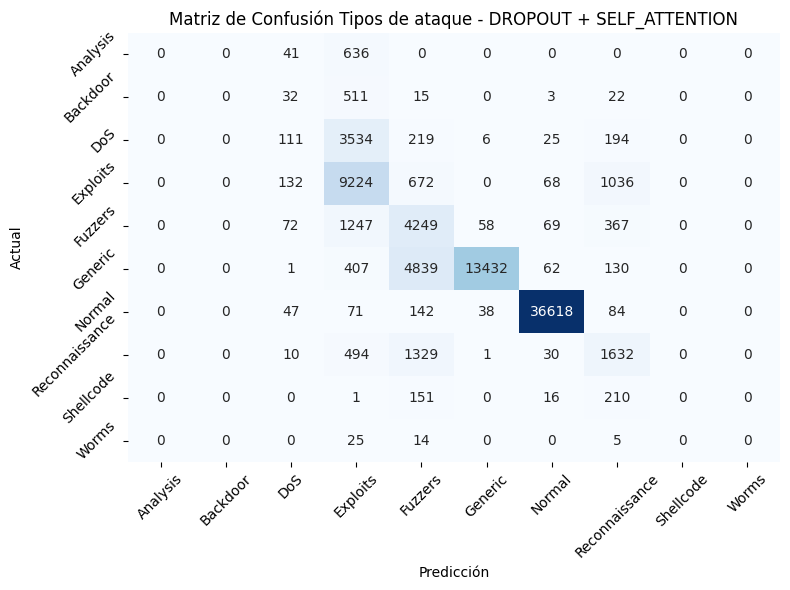

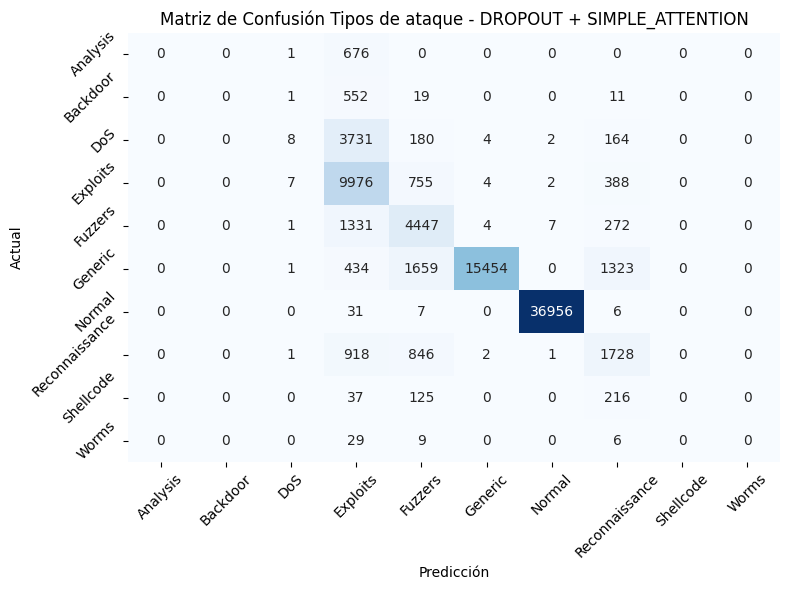

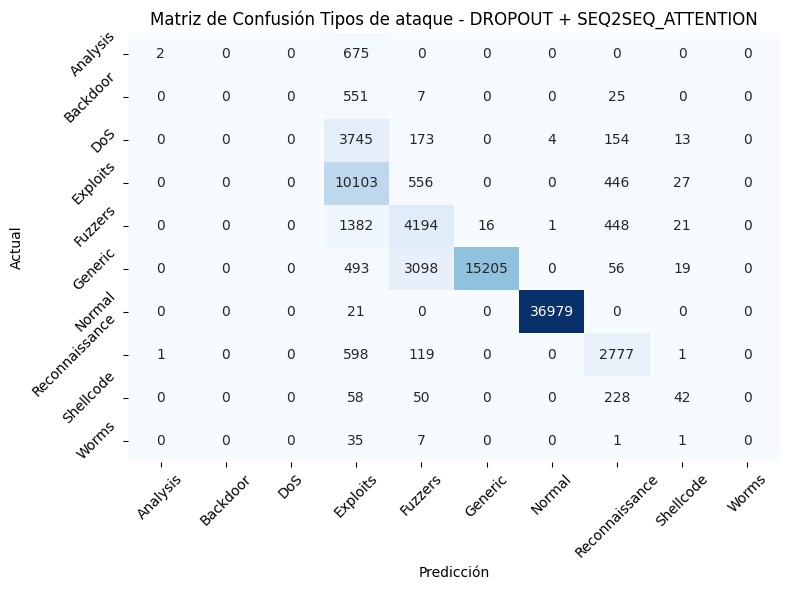

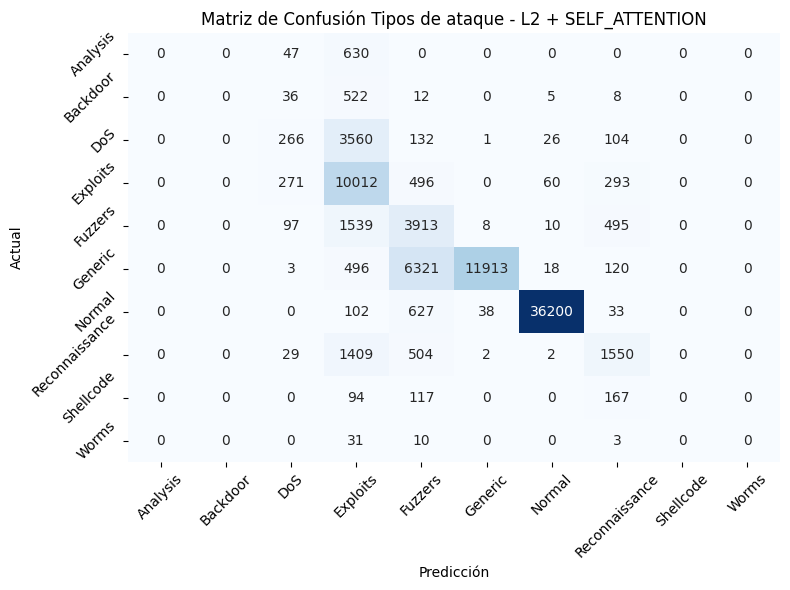

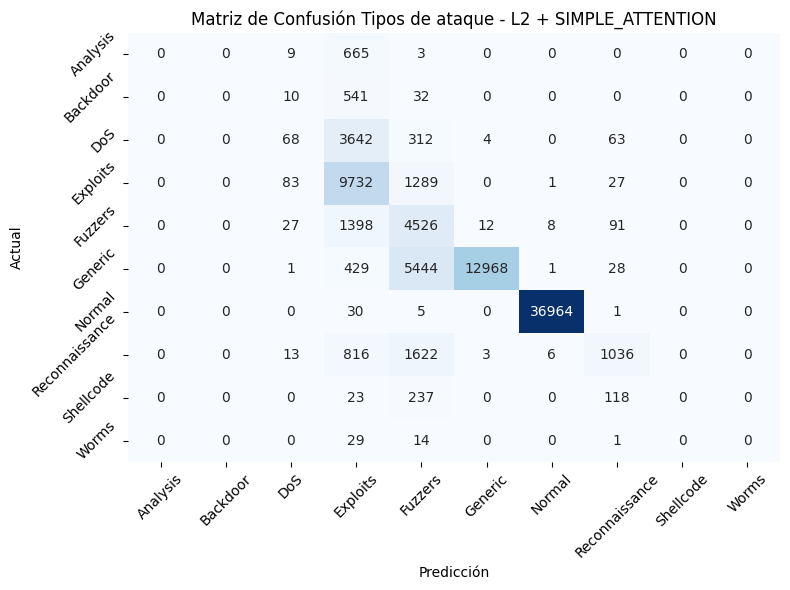

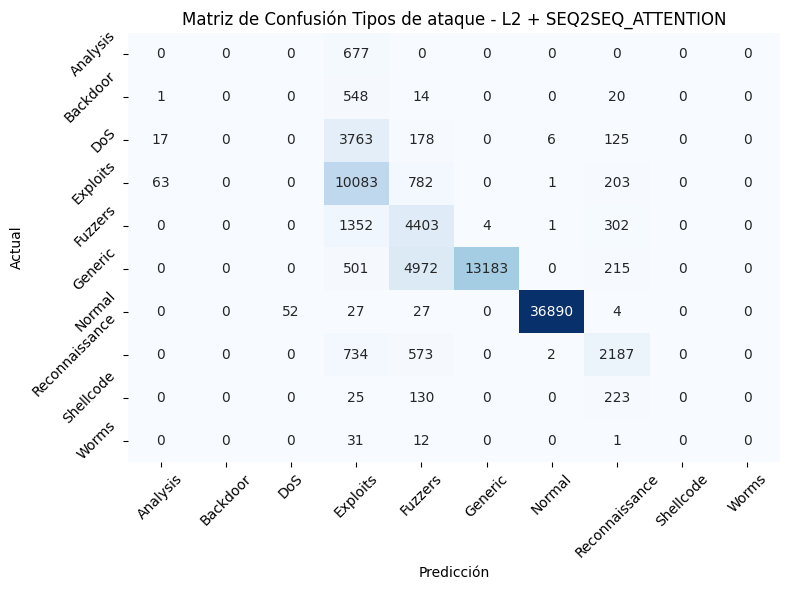

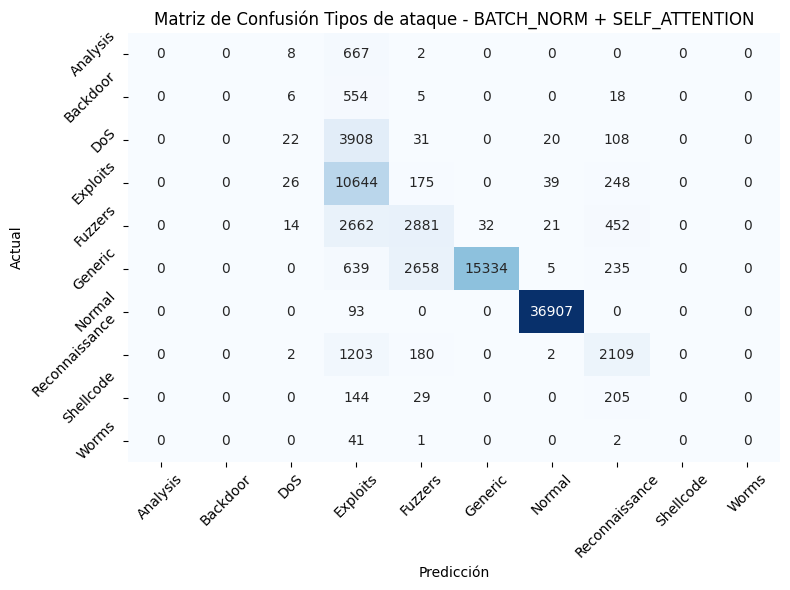

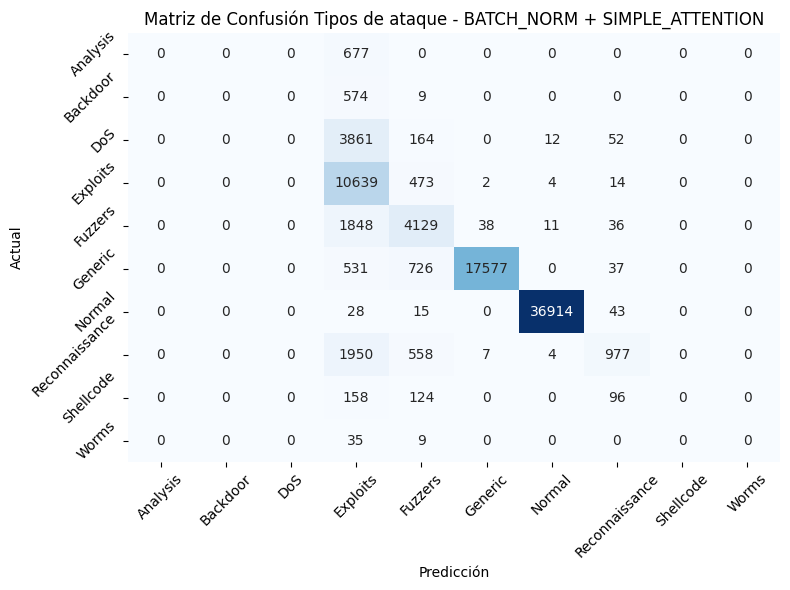

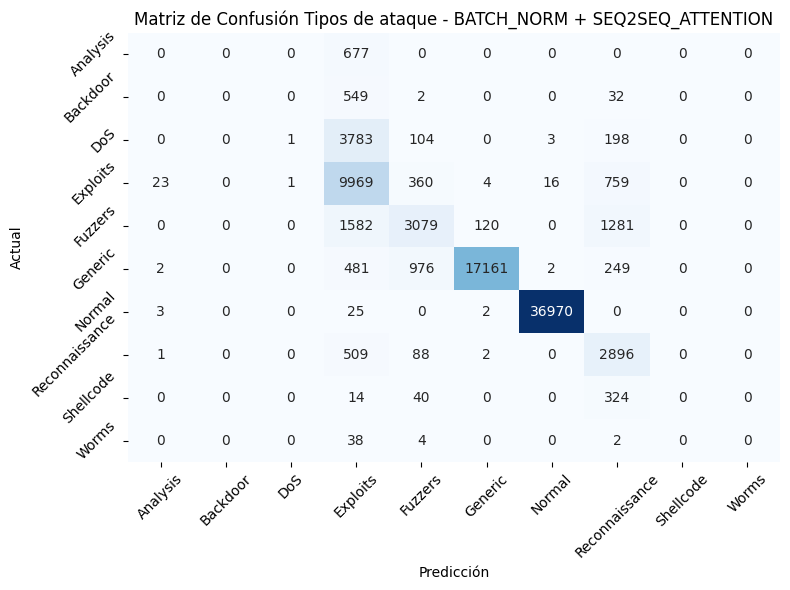

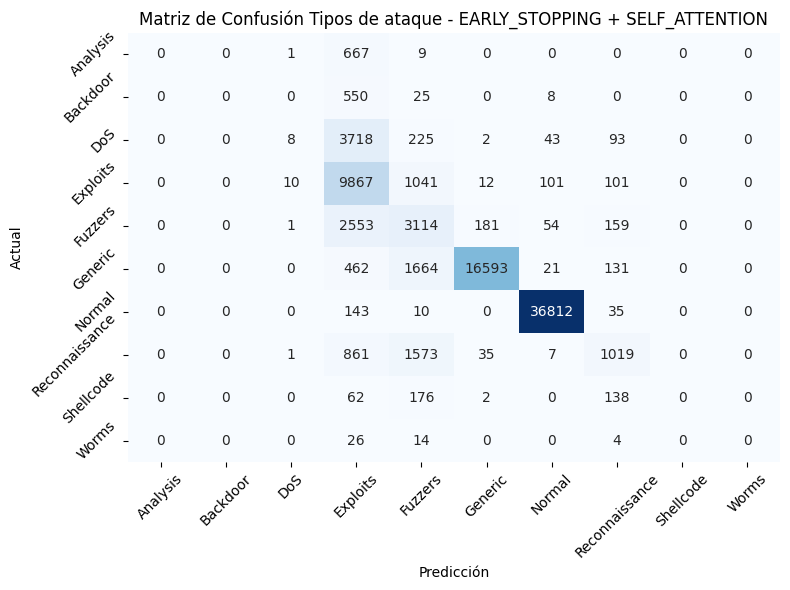

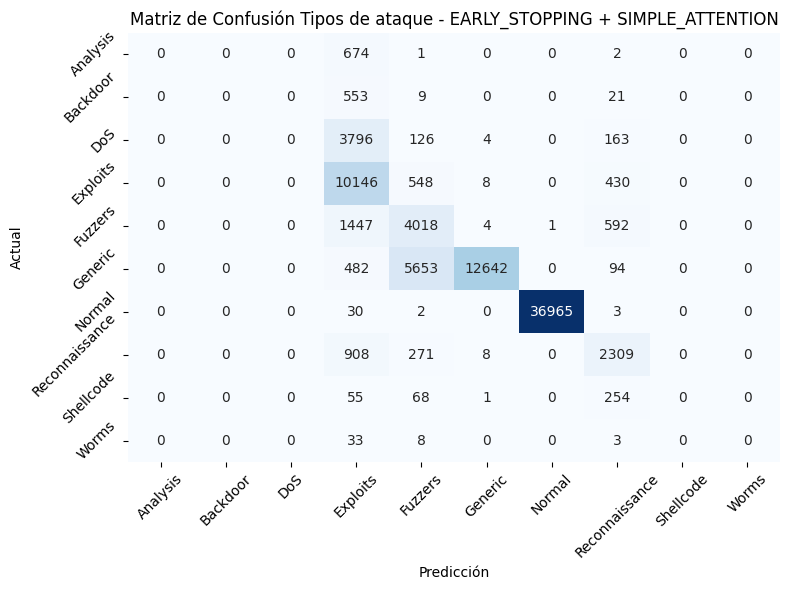

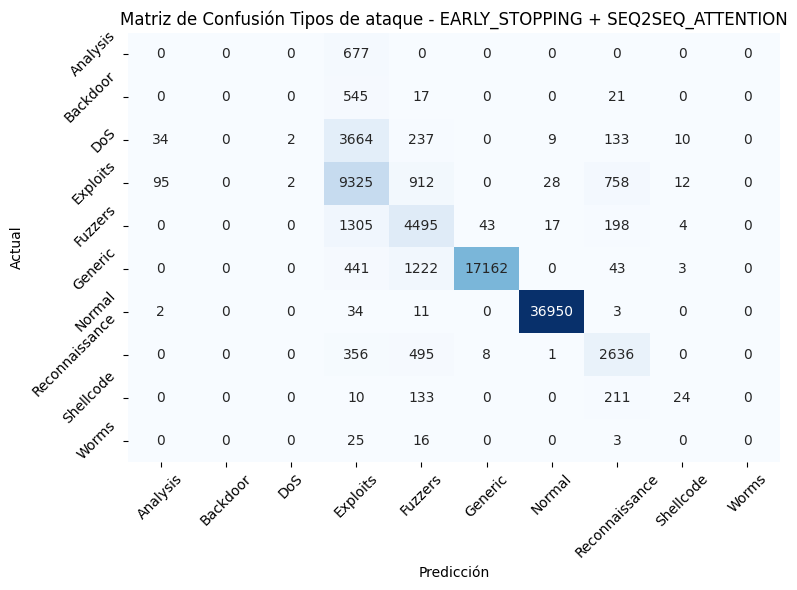

In [5]:
# graficar modelo
def plot_history(histories, model_names, metric='accuracy'):
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(histories):
        plt.plot(history.history[metric], label=model_names[i])
    plt.title(f'Evolución de {metric}')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Época')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

# Graficar accuracy y loss para modelos
plot_history(history_list, model_names, metric='accuracy')
plot_history(history_list, model_names, metric='loss')

# Matrices de confusión
def plot_confusion_matrices(confusion_matrices, model_names, classes, title_prefix):
    for i, cm in enumerate(confusion_matrices):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"{title_prefix} - {model_names[i]}")
        plt.xlabel('Predicción')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Matrices de confusión normal - ataque
plot_confusion_matrices(confusion_matrices_binary, model_names, classes=['Normal', 'Ataque'], title_prefix='Matriz de Confusión Normal-Ataque')

# Matriz de confusión tipos de atque
plot_confusion_matrices(confusion_matrices_multi, model_names, classes=label_encoder.classes_, title_prefix='Matriz de Confusión Tipos de ataque')
